In [1]:
from unet_prax.src.datas import *
from unet_prax.src.models import *
import matplotlib.pyplot as plt
import torchvision
writer = SummaryWriter()

/Users/mromano/opt/anaconda3/envs/unet_prax-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NotImplementedError: 

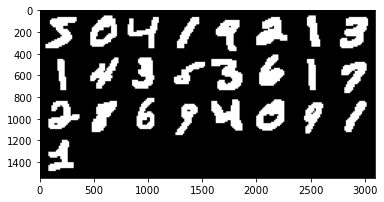

In [2]:

net = UNet(channel_list=(1,12,24,48,96,192,))

DEVICE = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

net.to(DEVICE)

loss_fun = nn.BCEWithLogitsLoss().to(DEVICE)
optim = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optim.zero_grad()

train_data = MnistData(True)
test_data = MnistData(False)

train_dataloader = DataLoader(train_data, batch_size=25, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data))
    

for samples, labels in train_dataloader:
    grid = torchvision.utils.make_grid(labels)
    plt.imshow(grid.permute(1,2,0))
    raise NotImplementedError

In [ ]:
from tqdm import tqdm

def train_model(n_epochs):
    for epoch in range(n_epochs):
        print(f'Epoch # {epoch}')
        for samples, labels in tqdm(train_dataloader):
            samples, labels = samples.to(DEVICE), labels.to(DEVICE)
            optim.zero_grad()
            out = net(samples)
            loss = loss_fun(out, transforms.CenterCrop(out.shape[2:3])(samples))
            writer.add_scalar('Loss/train', loss.item(), epoch)
            loss.backward()
            optim.step()
    
train_model(20)
writer.flush()

Epoch # 0


  8%|▊         | 197/2400 [01:36<18:02,  2.04it/s]


KeyboardInterrupt: 